# Определение перспективного тарифа для телеком компании
## Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание данных

### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана
### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок
### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение
### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя
### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты - будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
users = pd.read_csv('./datasets/users.csv')
calls = pd.read_csv('./datasets/calls.csv')
messages = pd.read_csv('./datasets/messages.csv')
internet = pd.read_csv('./datasets/internet.csv', index_col=0)
tariffs = pd.read_csv('./datasets/tariffs.csv')

## Шаг 1. Изучение общей информации

### Users

In [3]:
users.info()
print()
display(users.describe())
print()
users.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB



,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
487,1487,72,NaN,Кострома,Рудольф,Кириллов,2018-08-13,smart
178,1178,56,NaN,Москва,Наталья,Жарова,2018-05-15,smart
242,1242,39,2018-12-21,Хабаровск,Радим,Федосеев,2018-11-18,smart
316,1316,42,NaN,Улан-Удэ,Аурелия,Алымова,2018-11-29,smart
403,1403,18,NaN,Брянск,Ахмет,Амелин,2018-05-20,ultra
240,1240,30,NaN,Воронеж,Зинаида,Шарова,2018-02-27,ultra
249,1249,25,NaN,Курск,Изольда,Авдушева,2018-08-14,smart
310,1310,28,NaN,Уфа,Рудольф,Нестеров,2018-03-22,ultra
341,1341,71,NaN,Москва,Виктор,Кузнецов,2018-06-22,ultra
90,1090,54,2018-12-03,Череповец,Екатерина,Астафьева,2018-10-11,ultra


### Calls

In [4]:
calls.info()
print()
display(calls.describe())
print()
calls.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB



,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


,id,call_date,duration,user_id
56528,1143_592,2018-12-23,4.83,1143
148046,1375_877,2018-08-28,2.91,1375
7625,1021_93,2018-08-24,7.25,1021
49238,1123_257,2018-04-11,7.43,1123
202287,1498_80,2018-09-04,1.33,1498
149573,1377_420,2018-07-24,0.00,1377
110525,1284_123,2018-12-31,3.37,1284
50299,1125_34,2018-09-29,7.72,1125
39528,1098_356,2018-12-29,0.00,1098
54979,1138_404,2018-11-22,11.69,1138


### Messages

In [5]:
messages.info()
print()
display(messages.describe())
print()
messages.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB



,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


,id,message_date,user_id
97441,1400_13,2018-08-25,1400
102787,1419_76,2018-12-24,1419
77910,1327_407,2018-12-18,1327
45425,1196_875,2018-09-26,1196
44712,1196_162,2018-05-28,1196
6956,1029_35,2018-12-29,1029
46252,1200_147,2018-05-10,1200
75178,1318_207,2018-11-24,1318
107078,1432_10,2018-11-20,1432
91183,1378_13,2018-08-01,1378


### Internet

In [6]:
internet.info()
print()
display(internet.describe())
print()
internet.sample(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB



,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


,id,mb_used,session_date,user_id
102119,1341_234,75.94,2018-08-20,1341
67014,1227_611,564.03,2018-05-09,1227
130066,1433_261,654.56,2018-04-06,1433
144565,1482_366,0.00,2018-10-02,1482
22837,1076_477,511.64,2018-03-17,1076
6671,1021_315,382.36,2018-09-02,1021
127189,1427_8,0.00,2018-05-17,1427
62404,1211_237,72.96,2018-06-30,1211
70216,1239_237,635.49,2018-10-17,1239
149326,1499_87,163.64,2018-10-13,1499


### Tarifs

In [7]:
tariffs.info()
print()
display(tariffs.describe())
print()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes



,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


## Шаг 2. Подготовка данных

**Переводим даты из строки в тип datetime**

In [8]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [9]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [11]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


**Округляем минуты и гигабайты**

In [12]:
calls['duration'] = calls['duration'].apply(np.ceil)
display(calls.sample(20))
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
display(internet.sample(20))

,id,call_date,duration,user_id
158688,1392_353,2018-06-25,7.0,1392
139427,1356_411,2018-10-20,0.0,1356
74702,1186_524,2018-03-09,11.0,1186
69515,1174_555,2018-07-22,10.0,1174
171856,1425_468,2018-05-18,16.0,1425
69555,1174_595,2018-05-01,0.0,1174
196509,1481_316,2018-09-12,0.0,1481
179449,1448_149,2018-11-20,5.0,1448
100719,1259_63,2018-11-18,7.0,1259
101554,1261_172,2018-12-06,16.0,1261


,id,mb_used,session_date,user_id
27782,1097_88,302.0,2018-07-03,1097
126189,1424_50,0.0,2018-10-04,1424
42471,1148_59,275.0,2018-08-09,1148
106979,1363_25,503.0,2018-09-22,1363
148920,1497_34,70.0,2018-11-20,1497
107097,1363_143,993.0,2018-07-13,1363
125005,1421_190,632.0,2018-11-05,1421
120919,1408_227,433.0,2018-08-06,1408
97821,1330_29,0.0,2018-09-26,1330
53856,1180_347,622.0,2018-05-22,1180


Переделал вывод таблиц с print() на display()

**Нужно ли убрать звонки с 0 продолжительностью?**

,duration,user_id
count,202607.000000,202607.000000
mean,7.158198,1253.940619
std,5.959173,144.722751
min,0.000000,1000.000000
25%,2.000000,1126.000000
50%,6.000000,1260.000000
75%,11.000000,1379.000000
max,38.000000,1499.000000


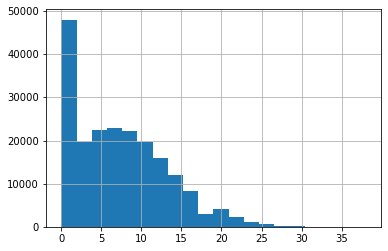

,duration,user_id
count,162994.000000,162994.000000
mean,8.897880,1254.149877
std,5.353761,144.751050
min,1.000000,1000.000000
25%,5.000000,1126.000000
50%,8.000000,1261.000000
75%,12.000000,1379.000000
max,38.000000,1499.000000


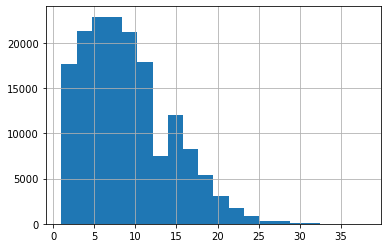

In [13]:
display(calls.describe())
calls['duration'].hist(bins=20)
plt.show()
print()
display(calls[calls['duration'] > 0].describe())
calls[calls['duration'] > 0]['duration'].hist(bins=20)
plt.show()

calls = calls[calls['duration'] > 0]

Как видно из графиков, звонков с продолжительностью 0 очень много, но эти записи портят характеристики, а именно среднее и медиану, т.к. для дальнейшего анализа эти данные не нужны, то лучше их отбросить. Это могут быть пропущенные звонки или сброщенные звонки. Те звонки звонки которые длились хотя бы одну секунду мы уже округлили в большую сторону.

**Нужно ли убрать сессии с 0 продолжительностью?**

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.622098,1252.099842
std,278.387019,144.050823
min,0.000000,1000.000000
25%,139.000000,1130.000000
50%,349.000000,1251.000000
75%,560.000000,1380.000000
max,1725.000000,1499.000000


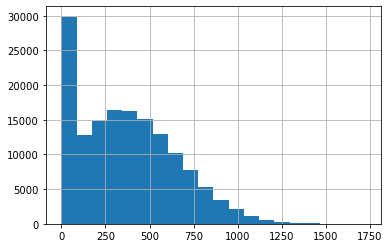

,mb_used,user_id
count,129798.000000,129798.000000
mean,426.581758,1253.046318
std,255.596114,143.782672
min,1.000000,1000.000000
25%,228.000000,1132.000000
50%,401.000000,1252.000000
75%,593.000000,1380.000000
max,1725.000000,1499.000000


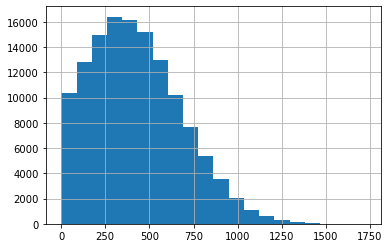

In [14]:
display(internet.describe())
internet['mb_used'].hist(bins=20)
plt.show()
print()
display(internet[internet['mb_used'] > 0].describe())
internet[internet['mb_used'] > 0]['mb_used'].hist(bins=20)
plt.show()

internet = internet[internet['mb_used'] > 0]

Как видно из графиков, инетрнет сессий с 0 mb очень много, но эти записи портят характеристики, а именно среднее и медиану, т.к. для дальнейшего анализа эти данные не нужны, то лучше их отбросить. Это могут быть сессии с маленьких количеством траффика или например из тех мест, где очень плохо ловит интернет. более значимые сессии мы уже округлили в большую сторону.

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [15]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls_by_months = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
calls_by_months.columns = ['calls_count', 'minutes_used']
calls_by_months.head(15)

calls_count  minutes_used
user_id month                           
1000    5               17         159.0
        6               28         172.0
        7               41         340.0
        8               42         408.0
        9               46         466.0
        10              44         350.0
        11              37         338.0
        12              38         333.0
1001    11              45         430.0
        12              47         414.0
1002    6               14         117.0
        7               21         214.0
        8               37         289.0
        9               25         206.0
        10              24         212.0

### Количество отправленных сообщений по месяцам

In [16]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages_by_months = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_by_months.columns = ['messages_used']
messages_by_months.head(15)

messages_used
user_id month               
1000    5                 22
        6                 60
        7                 75
        8                 81
        9                 57
        10                73
        11                58
        12                70
1002    6                  4
        7                 11
        8                 13
        9                  4
        10                10
        11                16
        12                12

### Объем израсходованного интернет-трафика по месяцам

In [17]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet_by_months = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_by_months.columns = ['mbs_used']
internet_by_months['gbs_used'] = internet_by_months['mbs_used'] / 1024
# internet_by_months['gbs_used'] = internet['mb_used'].apply(np.ceil)
internet_by_months.head(15)

mbs_used   gbs_used
user_id month                     
1000    5        2256.0   2.203125
        6       23257.0  22.711914
        7       14016.0  13.687500
        8       14070.0  13.740234
        9       14581.0  14.239258
        10      14717.0  14.372070
        11      14768.0  14.421875
        12       9827.0   9.596680
1001    11      18452.0  18.019531
        12      14053.0  13.723633
1002    6       10871.0  10.616211
        7       17601.0  17.188477
        8       20347.0  19.870117
        9       16712.0  16.320312
        10      13905.0  13.579102

**Объединяем данные в единный dataframe для дальнейшего анализа** 

In [18]:
usage = calls_by_months.join(messages_by_months, how='outer')
usage = usage.join(internet_by_months, how='outer')
usage.fillna({'calls_count': 0, 'minutes_used': 0, 'messages_used': 0, 'mbs_used': 0}, inplace=True)

usage.reset_index(level='month', inplace=True)

users_usage = users.merge(usage, on='user_id')
users_usage.drop(['first_name', 'last_name'], axis=1, inplace=True)
users_usage.info()
users_usage.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        3214 non-null   int64         
 1   age            3214 non-null   int64         
 2   churn_date     187 non-null    datetime64[ns]
 3   city           3214 non-null   object        
 4   reg_date       3214 non-null   datetime64[ns]
 5   tariff         3214 non-null   object        
 6   month          3214 non-null   int64         
 7   calls_count    3214 non-null   float64       
 8   minutes_used   3214 non-null   float64       
 9   messages_used  3214 non-null   float64       
 10  mbs_used       3214 non-null   float64       
 11  gbs_used       3201 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(3), object(2)
memory usage: 326.4+ KB


,user_id,age,churn_date,city,reg_date,tariff,month,calls_count,minutes_used,messages_used,mbs_used,gbs_used
0,1000,52,NaT,Краснодар,2018-05-25,ultra,5,17.0,159.0,22.0,2256.0,2.203125
1,1000,52,NaT,Краснодар,2018-05-25,ultra,6,28.0,172.0,60.0,23257.0,22.711914
2,1000,52,NaT,Краснодар,2018-05-25,ultra,7,41.0,340.0,75.0,14016.0,13.687500
3,1000,52,NaT,Краснодар,2018-05-25,ultra,8,42.0,408.0,81.0,14070.0,13.740234
4,1000,52,NaT,Краснодар,2018-05-25,ultra,9,46.0,466.0,57.0,14581.0,14.239258
5,1000,52,NaT,Краснодар,2018-05-25,ultra,10,44.0,350.0,73.0,14717.0,14.372070
6,1000,52,NaT,Краснодар,2018-05-25,ultra,11,37.0,338.0,58.0,14768.0,14.421875
7,1000,52,NaT,Краснодар,2018-05-25,ultra,12,38.0,333.0,70.0,9827.0,9.596680
8,1001,41,NaT,Москва,2018-11-01,smart,11,45.0,430.0,0.0,18452.0,18.019531
9,1001,41,NaT,Москва,2018-11-01,smart,12,47.0,414.0,0.0,14053.0,13.723633


**Рассчёт помесячной выручки**

In [19]:
def monthly_revenue(row):
    tariff = row['tariff']

    tariff_data = tariffs[tariffs['tariff_name'] == tariff].iloc[0]
    total = tariff_data['rub_monthly_fee']

    minutes_over_tariff = row['minutes_used'] - tariff_data['minutes_included']
    if minutes_over_tariff > 0:
        total += minutes_over_tariff * tariff_data['rub_per_minute']
    
    messages_over_tariff = row['messages_used'] - tariff_data['messages_included']
    if messages_over_tariff > 0:
        total += messages_over_tariff * tariff_data['rub_per_message']

    internet_over_tariff = row['mbs_used'] - tariff_data['mb_per_month_included']
    if internet_over_tariff > 0:
        total += np.ceil(internet_over_tariff / 1024) * tariff_data['rub_per_gb']

    return total

users_usage['monthly_revenue'] = users_usage.apply(monthly_revenue, axis=1)
users_usage['monthly_revenue'] = users_usage['monthly_revenue'].astype('int')

In [20]:
users_usage.sample(10)

,user_id,age,churn_date,city,reg_date,tariff,month,calls_count,minutes_used,messages_used,mbs_used,gbs_used,monthly_revenue
2364,1374,67,NaT,Махачкала,2018-04-01,smart,10,61.0,617.0,80.0,21340.0,20.839844,2191
998,1157,27,NaT,Москва,2018-02-23,smart,6,45.0,419.0,0.0,24864.0,24.281250,2550
2226,1353,57,2018-11-26,Санкт-Петербург,2018-04-22,smart,6,46.0,385.0,54.0,22537.0,22.008789,2162
2201,1346,69,NaT,Саратов,2018-07-03,ultra,12,111.0,869.0,50.0,4700.0,4.589844,1950
1968,1310,28,NaT,Уфа,2018-03-22,ultra,8,60.0,528.0,51.0,22838.0,22.302734,1950
829,1130,58,NaT,Тюмень,2018-04-01,smart,5,58.0,521.0,58.0,19453.0,18.997070,1437
1877,1295,19,NaT,Краснодар,2018-09-19,smart,11,27.0,240.0,97.0,20738.0,20.251953,1891
3118,1482,68,NaT,Санкт-Петербург,2018-02-28,smart,7,31.0,245.0,60.0,16385.0,16.000977,980
184,1028,20,NaT,Тверь,2018-10-02,ultra,11,106.0,1021.0,182.0,18215.0,17.788086,1950
1746,1275,48,NaT,Москва,2018-04-24,smart,12,49.0,364.0,17.0,14819.0,14.471680,550


## Шаг 3. Анализ данных

In [21]:
users_usage_grouped_by_tariff = users_usage.pivot_table(index='tariff', values=['minutes_used', 'messages_used', 'gbs_used'], aggfunc={'mean', 'var', 'std'}).round(2)
users_usage_grouped_by_tariff

gbs_used              messages_used                 minutes_used  \
           mean   std    var          mean    std      var         mean   
tariff                                                                    
smart     15.86  5.72  32.75         33.38  28.23   796.81       417.93   
ultra     19.25  9.70  94.17         49.36  47.80  2285.27       526.62   

                           
           std        var  
tariff                     
smart   190.31   36219.32  
ultra   317.61  100873.63

In [22]:
smart_users = users_usage[users_usage['tariff'] == 'smart']
ultra_users = users_usage[users_usage['tariff'] == 'ultra']

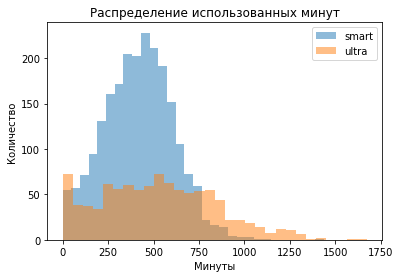

In [23]:
fig, ax = plt.subplots()
ax.hist(smart_users['minutes_used'], bins=30, alpha=0.5, label='smart')
ax.hist(ultra_users['minutes_used'], bins=30, alpha=0.5, label='ultra')
ax.set_title('Распределение использованных минут')
plt.xlabel('Минуты')
plt.ylabel('Количество')
plt.legend()
plt.show()

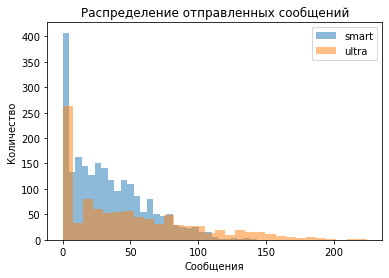

In [24]:
fig, ax = plt.subplots()
ax.hist(smart_users['messages_used'], bins=30, alpha=0.5, label='smart')
ax.hist(ultra_users['messages_used'], bins=30, alpha=0.5, label='ultra')
ax.set_title('Распределение отправленных сообщений')
plt.xlabel('Сообщения')
plt.ylabel('Количество')
plt.legend()
plt.show()

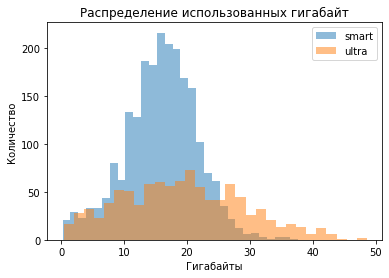

In [25]:
fig, ax = plt.subplots()
ax.hist(smart_users['gbs_used'], bins=30, alpha=0.5, label='smart')
ax.hist(ultra_users['gbs_used'], bins=30, alpha=0.5, label='ultra')
ax.set_title('Распределение использованных гигабайт')
plt.xlabel('Гигабайты')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [26]:
monthly_revenue_by_tariff = users_usage.pivot_table(index='tariff', values='monthly_revenue', aggfunc=['sum', 'mean'])
monthly_revenue_by_tariff

,sum,mean
,monthly_revenue,monthly_revenue
tariff,,
smart,2885751,1294.63930
ultra,2040000,2071.06599


**Выводы:** судя по гистограммам и сводной таблице 99% пользователей тарифа ультра не выходят за пределы включенных в тариф минут и сообщений, в отличии от пользователей тарифа смарт. А использование интернета в обоих тарифах часто выходит за пределы тарифа, в случае тарифа смарт этот показатель больше.

## Шаг 4. Проверка гипотез

In [27]:
alpha = .05

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

H0 - средняя выручка пользователей тарифов равна

H1 - средняя выручка тарифов пользователей различается

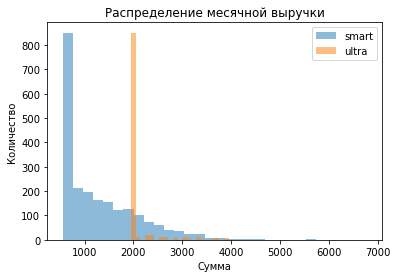

In [28]:
fig, ax = plt.subplots()
ax.hist(smart_users['monthly_revenue'], bins=30, alpha=0.5, label='smart')
ax.hist(ultra_users['monthly_revenue'], bins=30, alpha=0.5, label='ultra')
ax.set_title('Распределение месячной выручки')
plt.xlabel('Сумма')
plt.ylabel('Количество')
plt.legend()
plt.show()

Так как у нас две независимых выборки с диксретными величинами, распределение которых стремятся к нормальному, для проверки гипотезы мы используем критерий стъюдента.

In [29]:
mean_revenue_by_tariff_test = st.ttest_ind(
    smart_users['monthly_revenue'], 
    ultra_users['monthly_revenue'])

print('p-значение:', mean_revenue_by_tariff_test.pvalue)

if (mean_revenue_by_tariff_test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


**Вывод:** p-value показывает нам, что нет оснований принять нулевую гипотезу. 

**Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

H0 - средняя выручка пользователей тарифов из Москвы и не из Москвы равна

H1 - средняя выручка пользователей тарифов из Москвы и не из Москвы различается

In [30]:
moscow_users = users_usage[users_usage['city'] == 'Москва']
not_moscow_users = users_usage[~(users_usage['city'] == 'Москва')]

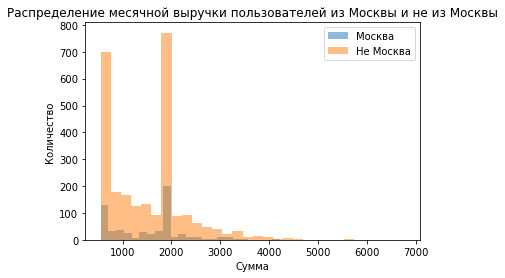

In [31]:
fig, ax = plt.subplots()
ax.hist(moscow_users['monthly_revenue'], bins=30, alpha=0.5, label='Москва')
ax.hist(not_moscow_users['monthly_revenue'], bins=30, alpha=0.5, label='Не Москва')
ax.set_title('Распределение месячной выручки пользователей из Москвы и не из Москвы')
plt.xlabel('Сумма')
plt.ylabel('Количество')
plt.legend()
plt.show()

Так как у нас две независимых выборки с диксретными величинами, распределение которых стремятся к нормальному, для проверки гипотезы мы также используем критерий стъюдента.

In [32]:
mean_revenue_from_moscow_by_tariff_test = st.ttest_ind(
    moscow_users['monthly_revenue'], 
    not_moscow_users['monthly_revenue'])

print('p-значение:', mean_revenue_from_moscow_by_tariff_test.pvalue)

if (mean_revenue_from_moscow_by_tariff_test.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.531666503831252
Не получилось отвергнуть нулевую гипотезу


**Вывод:** p-value показывает нам, что нет оснований отвергнуть нулевую гипотезу. 

## Шаг 5. Общий вывод

Проведя анализ данных и проверив гипотезы мы можем сделать вывод что тариф смарт принесет компании мегалайн больше прибыли, так как это более доступный тариф, его выбирают гораздо больше пользователей и эти пользователи чаще выходят за пределы тарифа, что приносит дополнительную прибыль, хоть и среднее значение прибыли у этого тарифа ниже, чем у тарифа ультра. Пользователи обоих тарифов чаще берут дополнительные гигабайты интернета, чем остальных услуг, а пользователи тарифа смарт ещё часто посылают сообщения, выйдя за пределы тарифа. Так же мы не смогли подтвердить гипотезу что, средняя выручка зависит от того в Москве находятся пользователи или нет.